In [1]:
# Standard library and path imports
import sys
import os
import time
import json
sys.path.append(".")
# Third-party library imports
import numpy as np
import pandas as pd
import shapely.ops as so
import shapely.geometry as sg
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx
import networkx as nx
import momepy

# Local or project-specific imports
from utils.helper import get_modified_edges_df
from router import Router
from utils.graph_op import graphOperator
from utils.dataparser import  create_network_graph, handle_weight, handle_weight_with_recovery
from utils.metrics import common_edges_similarity_route_df_weighted, get_virtual_op_list

import multiprocessing as mp
from copy import deepcopy 
from shapely import wkt
from utils.mthread import generate_neighbor_p, parallel_generate_neighbor



d:\ANACONDA\envs\crc_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LS():
    def __init__(self, args):
        self.args = args
    
    def reset(self):
        self.heuristic = self.args['heuristic']
        self.heuristic_f = self.args['heuristic_f']
        self.attrs_variable_names = self.args['attrs_variable_names']
        self.jobs = self.args['jobs']
        if self.jobs > 1:
            self.pool = mp.Pool(processes=self.jobs)
        else:
            self.pool = None
        

        self.df, self.path_foil, self.df_path_foil, self.gdf_coords_loaded = read_data(self.args)
        self.user_model = self.args["user_model"]
        self.meta_map = self.args["meta_map"]
        df_copy = deepcopy(self.df)
        df_copy = handle_weight(df_copy, self.user_model)
        _, self.G = create_network_graph(df_copy)
        self.df=df_copy

        self.router_h= Router(heuristic=self.heuristic, CRS=self.meta_map["CRS"], CRS_map=self.meta_map["CRS_map"])
        self.graph_operator = graphOperator()
        self.origin_node, self.dest_node, self.origin_node_loc, self.dest_node_loc, self.gdf_coords = self.router_h.set_o_d_coords(self.G, self.gdf_coords_loaded)

        self.path_fact, self.G_path_fact, self.df_path_fact = self.router_h.get_route(self.G, self.origin_node, self.dest_node, self.heuristic_f)
    
    def generate_neighbor(self, df):
        (df_perturbed_i, G_perturbed_i),(df_path_i, G_path_i), op_list_perturbed = generate_neighbor_p(df, self.router_h, self.graph_operator, self.origin_node, self.dest_node, self.args, self.user_model)
        if df_perturbed_i is None:
            return (None, None, 0), (None, None, 0), op_list_perturbed
        
        sub_op_list = get_virtual_op_list(self.df, df_perturbed_i, self.attrs_variable_names)
        graph_error = len([op for op in sub_op_list if op[3] == "success"])

        route_error = 1-common_edges_similarity_route_df_weighted(df_path_i, self.df_path_foil, self.attrs_variable_names)
        return (df_perturbed_i, G_perturbed_i, graph_error), (df_path_i, G_path_i, route_error), (op_list_perturbed, sub_op_list)

    
    def generate_population(self, df, pop_num):
        pop = []
        if self.jobs > 1:
            jobs = [self.pool.apply_async(parallel_generate_neighbor, (df, self.router_h, self.graph_operator, self.origin_node, self.dest_node, self.df_path_foil, self.args, self.user_model, )) for _ in range(pop_num)]
            for idx, j in enumerate(jobs):
                try:
                    (df_perturbed_i, G_perturbed_i, graph_error), (df_path_i, G_path_i, route_error), op_lists = j.get()
                except Exception as e:
                    print(e)
                    (df_perturbed_i, G_perturbed_i, graph_error), (df_path_i, G_path_i, route_error), op_lists = (0, 0, 0), (0, 0, 0), []

                pop.append(((df_perturbed_i, G_perturbed_i, graph_error), (df_path_i, G_path_i, route_error), op_lists))
        else:
            for _ in range(pop_num):
                pop.append((self.generate_neighbor(df)))
        return pop

    def get_perturbed_edges(self, df_perturbed):
        modified_edges_df = get_modified_edges_df(self.df, df_perturbed, self.attrs_variable_names)
        return modified_edges_df


def read_data(args):

    basic_network_path = args['basic_network_path']
    foil_json_path = args['foil_json_path']
    df_path_foil_path = args['df_path_foil_path']
    gdf_coords_path = args['gdf_coords_path']

    df = gpd.read_file(basic_network_path)
    with open(foil_json_path, 'r') as f:
        path_foil = json.load(f)

    df_path_foil = gpd.read_file(df_path_foil_path)
    gdf_coords_loaded = pd.read_csv(gdf_coords_path, sep=';')

    gdf_coords_loaded['geometry'] = gdf_coords_loaded['geometry'].apply(wkt.loads)
    gdf_coords_loaded = gpd.GeoDataFrame(gdf_coords_loaded, geometry='geometry')

    return df, path_foil, df_path_foil, gdf_coords_loaded

In [ ]:
import multiprocessing as mp
from utils.parallel_utils import eval_edge_top
# route_name =  "demo_walk"
# route_id = "1"
# basic_network_path = f'./data/train/{route_name}/network_demo_walk_{route_id}'
# foil_json_path = f'./data/train/{route_name}/route_nodes_demo_walk_{route_id}.json'
# df_path_foil_path = f'./data/train/{route_name}/route_demo_walk_{route_id}'
# gdf_coords_path = f'./data/train/{route_name}/route_demo_walk_{route_id}_start_end.csv'
# meta_data_path = f'./data/train/{route_name}/metadata_{route_name}_{route_id}.json'
# route_name = "osdpm_0_4"  # 当前routes子文件夹
# route_id = "0"             # 如果有编号你自己补上

# basic_network_path = f'./data/train/maps/osdpm_segment_{route_id}.gpkg'  # 路网分块
# foil_json_path     = f'./data/train/routes/{route_name}/foil_route.json'
# df_path_foil_path  = f'./data/train/routes/{route_name}/foil_route.gpkg'  # 路径表
# gdf_coords_path    = f'./data/train/routes/{route_name}/route_start_end.csv'
# meta_data_path     = f'./data/train/routes/{route_name}/metadata.json'
# with open(meta_data_path, 'r') as f:
#     meta_data = json.load(f)
# ─────── 全局变量 ───────
BASE_DIR   = './data/train'
MAPS_DIR   = os.path.join(BASE_DIR, 'maps')
ROUTES_DIR = os.path.join(BASE_DIR, 'routes')
MAP_FMT    = 'osdpm_segment_{}.gpkg'   # 路网文件的命名
results1 = []
# ─────── 批量处理 ───────
for route_name in sorted(os.listdir(ROUTES_DIR)):
    start_time = time.time()
    route_folder = os.path.join(ROUTES_DIR, route_name)
    if not os.path.isdir(route_folder):
        continue
    print(route_name)
    parts = route_name.split('_')
    if len(parts) != 3:
        print(f"跳过非标准目录：{route_name}")
        continue
    _, seg_id, rid = parts

    # —— 构造各类文件路径 —— #
    basic_network_path = os.path.join(MAPS_DIR, MAP_FMT.format(seg_id))
    foil_json_path     = os.path.join(route_folder, 'foil_route.json')
    df_path_foil_path  = os.path.join(route_folder, 'foil_route.gpkg')
    gdf_coords_path        = os.path.join(route_folder, 'route_start_end.csv')
    meta_data_path     = os.path.join(route_folder, 'metadata.json')
    with open(meta_data_path, 'r') as f:
        meta_data = json.load(f)
    # Profile settings
    user_model = meta_data["user_model"]
    meta_map = meta_data["map"]

    attrs_variable_names = user_model["attrs_variable_names"]
    route_error_delta = user_model["route_error_threshold"]
    # Demo route

    n_perturbation = 50
    operator_p = [0.15, 0.15, 0.15, 0.15, 0.4]
    args = {
        'basic_network_path': basic_network_path,
        'foil_json_path': foil_json_path,
        'df_path_foil_path': df_path_foil_path,
        'gdf_coords_path': gdf_coords_path,
        'heuristic': 'dijkstra',
        'heuristic_f': 'my_weight',
        'jobs': 1,
        'attrs_variable_names': attrs_variable_names,
        "n_perturbation": n_perturbation,
        "operator_p": operator_p,
        "user_model": user_model,
        "meta_map": meta_map
    }

    # 1.1 实例化 LS 并 reset，内部已经调用 handle_weight 和 create_network_graph
    ls = LS(args)
    ls.reset()

    # 1.2 从 LS 拿到图 G（有向、多重图），以及原始的 DF 和 foil 路径 DF
    G = ls.G  # 由 create_network_graph(handle_weight(df)) 生成，图上每条边上的属性已包含 my_weight
    print(f"地图上的节点总数：{G.number_of_nodes()}")
    print(f"地图上的边总数：{G.number_of_edges()}")
    df_original = ls.df               # GeoDataFrame，已经被 handle_weight 过
    df_path_foil = ls.df_path_foil    # GeoDataFrame，foil 路径的边，用于计算相似度
    iteration = 0
    change1=True
    change2=True
    change3=True
    change4=True
    if(user_model["max_curb_height"]>0.2):
        change1=False
    if(user_model["min_sidewalk_width"]>2):
        change2=False
    if(user_model["max_curb_height"]<0):
        change3=False
    if(user_model["min_sidewalk_width"]<0.6):
        change4=False
    print(change1)
    print(change2)
    print(change3)
    print(change4)
    iteration = 0
    df_perturbed = ls.df.copy()
    df_perturbed["edge_idx"] = df_perturbed.index

    df_full_idx = df_perturbed.set_index("geometry", drop=False)
    df_foil_idx = ls.df_path_foil.set_index("geometry")
    full_only_cols = df_full_idx.columns.difference(df_foil_idx.columns)



    # 只把这些 “独有” 列拼过来
    df_foil_all = df_foil_idx.join(
        df_full_idx[full_only_cols],
        how="left"
    ).reset_index(drop=True)

    for idx, foil_row in ls.df_path_foil.iterrows():
        # idx 是 ls.df_path_foil 里这一行的索引
        foil_geom = foil_row["geometry"]

        # 在完整网络表 ls.df 里匹配相同 geometry，拿到对应行号列表
        orig_matches = ls.df.index[ls.df["geometry"] == foil_geom].tolist()

        if len(orig_matches) == 0 or len(orig_matches) > 1:
            print("error: geometry 没找到 或 匹配多于 1 条，跳过这一条")
            continue

        orig_idx = orig_matches[0]

        # 把找到的 orig_idx 写回到 ls.df_path_foil 的 edge_idx 列
        ls.df_path_foil.loc[idx, "edge_idx"] = orig_idx

        # 以下如果想还原 df_perturbed 中这条边的 include/属性，也可以用 orig_idx 去操作 df_perturbed
        if df_perturbed.loc[orig_idx, "include"] == 0:
            if df_perturbed.loc[orig_idx, "curb_height_max"] > user_model["max_curb_height"]:
                df_perturbed.loc[orig_idx, "curb_height_max"] = user_model["max_curb_height"]
                iteration += 1

            if df_perturbed.loc[orig_idx, "obstacle_free_width_float"] < user_model["min_sidewalk_width"]:
                df_perturbed.loc[orig_idx, "obstacle_free_width_float"] = user_model["min_sidewalk_width"]
                iteration += 1

            df_perturbed.loc[orig_idx, "include"] = 1
            print(orig_idx)
    G_con_dir, G_sel_con_dir = create_network_graph(df_perturbed)
    ls.G = G_sel_con_dir
    df_G=ls.G
    edge_index_map = {}
    for u, v, key, data in ls.G.edges(keys=True, data=True):
        idx = data.get("edge_idx")
        if idx is not None:
            edge_index_map[idx] = (u, v, key)
    print(f"edge_index_map 中的条目数: {len(edge_index_map)}")
    print(iteration)
    fact_path, G_fact_path, df_fact_path = ls.router_h.get_route(
        ls.G, ls.origin_node, ls.dest_node, ls.heuristic_f
    )

    sim_old = common_edges_similarity_route_df_weighted(df_fact_path, ls.df_path_foil, attrs_variable_names)
    route_error_old = 1.0 - sim_old
    print(df_foil_all["my_weight"].sum())
    print(df_fact_path["my_weight"].sum())
    print(route_error_old)
    print(f"[迭代 {iteration} 开始] 初始 route_error = {route_error_old:.5f}")
    if route_error_old <= route_error_delta:
        print("初始就已满足阈值，程序结束。")
        # …如果你想要在这里输出最终结果，可以补上
        exit(0)
    # 进入到正式的迭代循环
    last_route_error=route_error_old
    last_weight=df_fact_path["my_weight"].sum()
    cnt=0
    gen_log  = []   # 每次对某条边扰动后的记录
    best_log = []   # 每轮选出的最佳扰动记录
    new_route_error=None
    while True:
        foil_edge_idxs = set(df_foil_all["edge_idx"])
        fact_edge_idxs = set(df_fact_path["edge_idx"])
        # 2. 计算三类边
        common_edges      = foil_edge_idxs & fact_edge_idxs        # 交集：既在 foil 也在 fact 中的边
        foil_only_edges   = foil_edge_idxs - fact_edge_idxs        # 只在 foil 中出现的边
        fact_only_edges   = fact_edge_idxs - foil_edge_idxs        # 只在 fact 中出现的边
        print(f"第{cnt}轮删边")
        # 3. 打印一下规模，确认无误
        print(f"公共边数量:      {len(common_edges)}")
        print(f"Foil 独有边数量: {len(foil_only_edges)}")
        print(f"Fact 独有边数量: {len(fact_only_edges)}")
        df_common = df_perturbed.loc[list(common_edges)]
        df_foil_only = df_perturbed.loc[list(foil_only_edges)]
        df_fact_only = df_perturbed.loc[list(fact_only_edges)]
        # ---------- 贪心删边 ----------
        best_score = -float("inf")
        best_idx = None
        best_fact_path = None
        best_df = None
        if(new_route_error!=None):
            last_route_error=new_route_error

        inputs = [
            (
                idx,                  # 1. idx
                df_perturbed,         # 2. df_perturbed
                df_fact_path,         # 3. df_fact_path
                df_path_foil,      # 4. df_path_foil
                user_model,           # 5. user_model
                last_route_error,     # 6. last_route_error
                attrs_variable_names, # 7. attrs_variable_names
                ls.origin_node,       # 8. origin_node
                ls.dest_node,         # 9. dest_node
                ls.router_h.get_route, # 10. router_fun
                df_G,
                edge_index_map,
            )
            for idx in fact_only_edges
        ]

        if args["jobs"] > 1:
            print("GO")
            with mp.Pool(processes=args["jobs"]) as pool:
                results = pool.starmap(eval_edge_top, inputs)
        else:
            results = [eval_edge_top(*inp) for inp in inputs]

        valid = [r for r in results if r is not None]
        if not valid:
            print("所有扰动都不可行，退出循环")
            break

        best_score, best_idx, best_df, best_fact_path, best_err,new_df_G = max(
            valid, key=lambda x: x[0]
        )
        if best_idx is None:
            print("无可删边，或全部删过，退出循环")
            break

        print(f"本轮实际删边：{best_idx}，score={best_score:.3f}")
        print(f"相似度变化：{last_route_error:.3f}->{best_err:.3f}")
        print(f"权值变化：{df_fact_path['my_weight'].sum():.3f}->{best_fact_path['my_weight'].sum():.3f}")
        # 真正生效
        print(df_perturbed["include"].sum())
        print(best_df["include"].sum())
        df_perturbed = best_df
        df_fact_path = best_fact_path
        new_route_error=best_err
        df_G=new_df_G
        cnt += 1
        if best_err <= route_error_delta:
            print("达到阈值，退出循环")
            print(f"目前相似度{best_err}")
            print(f"总共进行了{cnt+iteration}次扰动")
            end_time = time.time()
            duration = end_time - start_time
            break
    results1.append({
        "route_name": route_name,
        "perturbation_steps": cnt + iteration,        # 总扰动次数
        "initial_similarity": route_error_old,  # 初始相似度
        "final_similarity": best_err,   # 或 best_err
        "duration_sec": duration, 
    })
print(results1)
df1 = pd.DataFrame(results1)
df1.to_csv("perturbation_summary.csv", index=False, encoding="utf-8-sig")
    # while True:
    #     foil_edge_idxs = set(df_foil_all["edge_idx"])
    #     fact_edge_idxs = set(df_fact_path["edge_idx"])

    #     # 2. 计算三类边
    #     common_edges      = foil_edge_idxs & fact_edge_idxs        # 交集：既在 foil 也在 fact 中的边
    #     foil_only_edges   = foil_edge_idxs - fact_edge_idxs        # 只在 foil 中出现的边
    #     fact_only_edges   = fact_edge_idxs - foil_edge_idxs        # 只在 fact 中出现的边
    #     print(f"第{cnt}轮删边")
    #     # 3. 打印一下规模，确认无误
    #     print(f"公共边数量:      {len(common_edges)}")
    #     print(f"Foil 独有边数量: {len(foil_only_edges)}")
    #     print(f"Fact 独有边数量: {len(fact_only_edges)}")
    #     df_common = df_perturbed.loc[list(common_edges)]
    #     df_foil_only = df_perturbed.loc[list(foil_only_edges)]
    #     df_fact_only = df_perturbed.loc[list(fact_only_edges)]
    #      # ---------- 贪心删边 ----------
    #     best_score = -float("inf")
    #     best_idx = None
    #     best_fact_path = None
    #     best_df = None
    #     new_route_error=None
    #     if(new_route_error!=None):
    #         last_route_error=new_route_error
    #     for idx in df_fact_only["edge_idx"]:
    #         # 备份并扰动
    #         df_tmp = df_perturbed.copy()
    #         if(change1):
    #             if df_tmp.loc[idx, "curb_height_max"] <= user_model["max_curb_height"]:
    #                 df_tmp.loc[idx, "curb_height_max"] = 0.2
    #                 df_tmp.loc[idx, "include"] = 0
    #                 print(1)
    #             else:
    #                 if(change2):
    #                     if df_tmp.loc[idx, "obstacle_free_width_float"] >= user_model["min_sidewalk_width"]:
    #                         df_tmp.loc[idx, "obstacle_free_width_float"] = 0.6
    #                         df_tmp.loc[idx, "include"] = 0
    #                         print(2)
    #                     else:
    #                         print("无法扰动，error")
    #                 else:
    #                     print("无法扰动，error")
    #         else:
    #             print("无法扰动，error")
    #         # 你的扰动逻辑可以更细，比如阈值，这里按include=0简单演示
    #         # 建图
            
    #         try:
    #             _,G_tmp = create_network_graph(df_tmp)
    #             fact_path_new, _, df_fact_path_new = ls.router_h.get_route(
    #                 G_tmp, ls.origin_node, ls.dest_node, ls.heuristic_f
    #             )
    #         except Exception as e:
    #             print(f"删边 {idx} 后不可达/异常，跳过: {e}")
    #             continue
    #         df_fact_path_new_set = set(df_fact_path_new["edge_idx"])
    #         df_fact_path_set = set(df_fact_path["edge_idx"])
    #         print("fact-only-new edges:", df_fact_path_new_set - df_fact_path_set)
    #         print("fact-only-old edges:", df_fact_path_set - df_fact_path_new_set)
    #         print("common edges:", df_fact_path_new_set & df_fact_path_set)
    #         dist=df_fact_path_new["my_weight"].sum()
    #         weight_delta = dist-df_fact_path["my_weight"].sum()
    #         sim_new = common_edges_similarity_route_df_weighted(df_fact_path_new, ls.df_path_foil, attrs_variable_names)
    #         route_error_new = 1.0 - sim_new
    #         last_route_error_delta=last_route_error-route_error_new
    #         score = weight_delta +  last_route_error_delta  # 调参，怎么组合自己玩
    #         gen_log.append((
    #             cnt,             # 第几轮
    #             idx,        # 尝试删的边
    #             dist,    # weighted_error
    #             route_error_new  # route_error
    #         ))
    #         print(f"尝试删 {idx} | Δweight={weight_delta:.10f} | Δroute_error={last_route_error_delta:.10f} | score={score:.10f}")
    #         if score > best_score:
    #             best_score = score
    #             best_idx = idx
    #             best_fact_path = df_fact_path_new.copy()
    #             new_route_error=route_error_new
    #             best_df = df_tmp.copy()
    #             best_log.append((
    #                 cnt,
    #                 best_idx,
    #                 best_fact_path["my_weight"].sum(),
    #                 route_error_new
    #             ))

    #     if best_idx is None:
    #         print("无可删边，或全部删过，退出循环")
    #         break

    #     print(f"本轮实际删边：{best_idx}，score={best_score:.3f}")
    #     # 真正生效
    #     print(df_perturbed["include"].sum())
    #     print(best_df["include"].sum())
    #     df_perturbed = best_df
    #     df_fact_path = best_fact_path
    #     # 判断终止条件
    #     cnt+=1
    #     print("fact_path 边 edge_idx:", best_fact_path["edge_idx"].tolist())
    #     print(new_route_error)
    #     if (new_route_error < route_error_delta):
    #         print("满足终止条件，结束")
    #         break
    # print(f"目前相似度{new_route_error}")
    # print(f"总共进行了{cnt+iteration}次扰动")

osdpm_2_5
地图上的节点总数：2136
地图上的边总数：5057
True
True
True
True
edge_index_map 中的条目数: 2658
0
1.7974123076923076
1.6694184615384613
0.4856481
[迭代 0 开始] 初始 route_error = 0.48565
第0轮删边
公共边数量:      147
Foil 独有边数量: 112
Fact 独有边数量: 78
2
fact-only-new edges: {1152, 1472, 1504, 1155, 1156, 1575, 1064, 1448, 1101, 1454, 1072, 1521, 1748, 1781, 1463, 380, 1790}
fact-only-old edges: {1281, 3074, 1411, 3076, 1284, 3078, 1410, 1413, 1416, 386, 1419, 1421, 1806, 1807, 1168, 1808, 3090, 1424, 3092, 1813, 1812, 1425, 1426, 1427, 1435, 3102, 3105, 3106, 3107, 3108, 1065, 1067, 1068, 1069, 1070, 3122, 3123, 3124, 3125, 3126, 439, 440, 442, 1339, 445, 1222, 1739, 1740, 461, 1743, 463, 1370, 3071, 1756, 1758, 1761, 1763, 1252, 3043, 1256, 3048, 3051, 3054, 3055, 3063, 3067, 383}
common edges: {4636, 4637, 4638, 4151, 4152, 2139, 2141, 2143, 2145, 2147, 2180, 3204, 3207, 2184, 3210, 3211, 2188, 2189, 2193, 3218, 2199, 3223, 3225, 2203, 3227, 3231, 2218, 2732, 2734, 2222, 2224, 4276, 2740, 4278, 2229, 4281, 2234, 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# Extract best-only data from your logs
iterations   = [e[0] for e in best_log]
weight_sums  = [e[2] for e in best_log]
similarities = [e[3] for e in best_log]

# Best Weight Sum curve
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(iterations, weight_sums, marker='s', linestyle='-', label='Best Weight Sum')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Weight Sum')
ax1.set_title('Best Weight Sum per Iteration')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend()
ax1.grid(True)
plt.tight_layout()
plt.show()

# Best Similarity curve
fig, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(iterations, similarities, marker='s', linestyle='-', label='Best Similarity')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Similarity')
ax2.set_title('Best Similarity per Iteration')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'best_log' is not defined

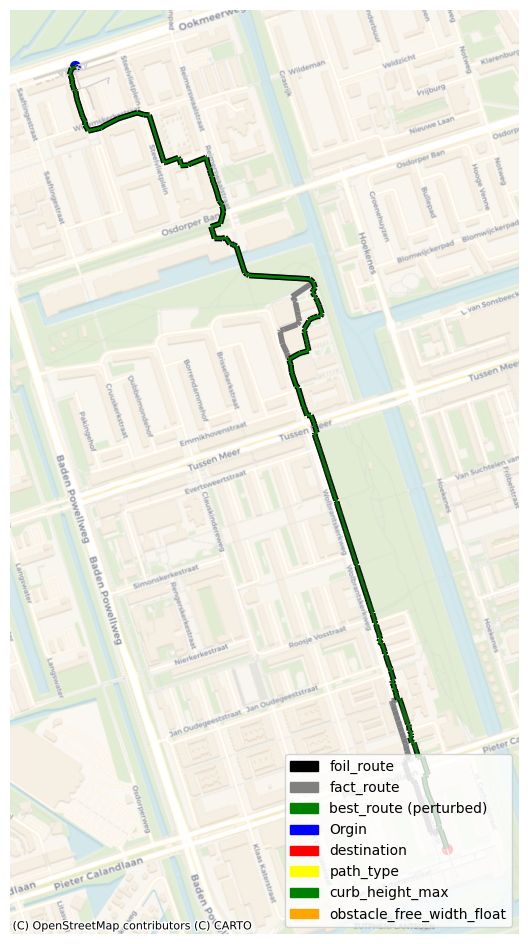

In [ ]:
gdf_coords = ls.gdf_coords.copy()
origin_node_loc_length = ls.origin_node_loc
dest_node_loc_length = ls.dest_node_loc

# Subset network for plotting
my_rad = 70
gdf_coords['buffer'] = gdf_coords['geometry'].buffer(my_rad, cap_style=3)
plot_area = gpd.GeoDataFrame(geometry=[gdf_coords['buffer'][0].union(gdf_coords['buffer'][1])], crs=meta_map["CRS"])
df_sub = gpd.sjoin(ls.df, plot_area, how='inner').reset_index()


attrs_color = {"path_type": {"c":"yellow","ls": "-", "lw": 5}, 
               "curb_height_max": {"c":"green","ls": "-", "lw": 4}, 
               "obstacle_free_width_float": {"c":"orange","ls": "-", "lw": 3}}
fig, ax = plt.subplots(figsize=(12,12))

# Network
df_sub.plot(ax=ax, color='lightgrey', linewidth=1)

ls.df_path_fact.plot(ax=ax, color='grey', linewidth=4)
ls.df_path_foil.plot(ax=ax, color='black', linewidth=4)
df_fact_path.plot(ax=ax, color='green', linewidth=2)

# not_common_edges_df.plot(ax=ax, color='yellow', linewidth=2)
# Origin and destination location
gdf_coords.head(1).plot(ax=ax, color='blue', markersize=50)
gdf_coords.tail(1).plot(ax=ax, color='red', markersize=50)

# Origin and destination nodes
gpd.GeoSeries([origin_node_loc_length], crs=meta_map["CRS"]).plot(ax=ax, color='blue', markersize=20)
gpd.GeoSeries([dest_node_loc_length], crs=meta_map["CRS"]).plot(ax=ax, color='red', markersize=20)

# Background
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Voyager, crs=meta_map["CRS"])

# Legend
route_acc = mpatches.Patch(color='black', label='foil_route')
route = mpatches.Patch(color='grey', label='fact_route')
route_best = mpatches.Patch(color='green', label='best_route (perturbed)')
origin = mpatches.Patch(color='blue', label= 'Orgin')
dest = mpatches.Patch(color='red', label= 'destination')
legend_handles = [route_acc,route,route_best,origin,dest]
for attr, color in attrs_color.items():
    legend_handles.append(mpatches.Patch(color=color["c"], label=attr))


plt.legend(handles=legend_handles,loc="lower right")

plt.axis('off')

plt.show()

# Store results

In [ ]:
from utils.dataparser import store_op_list, load_op_list
from utils.graph_op import pertub_with_op_list
from utils.dataparser import convert
from shapely import to_wkt
import json


ls.reset()
v_op_list = get_virtual_op_list(ls.df, df_perturbed, args["attrs_variable_names"])
available_op = [(op[0], (convert(op[1][0]), to_wkt(op[1][1], rounding_precision=-1, trim=False)), convert(op[2]), op[3]) for op in v_op_list if op[3] == "success"]
#test store and load op list
store_path = "./examples/demo_walk/outputs/"
store_op_path = f'{store_path}op_list_{route_name}_{route_id}.json'
with open(store_op_path, 'w') as f:
    json.dump(available_op, f)

df_fact_path.to_file(f'{store_path}p_route_{route_name}_{route_id}', driver='GPKG')
df_perturbed.to_file(f'{store_path}p_network_{route_name}_{route_id}', driver='GPKG')

# route_name = "osdpm_0_4"  # 当前routes子文件夹
# route_id = ""             # 如果有编号你自己补上

# basic_network_path = './examples/demo_walk/outputs/p_network_osdpm_0_4_.gpkg'  # 路网分块
# foil_json_path     = f'./data/train/routes/{route_name}/foil_route.json'
# df_path_foil_path  = f'./data/train/routes/{route_name}/foil_route.gpkg'  # 路径表
# gdf_coords_path    = f'./data/train/routes/{route_name}/route_start_end.csv'
# meta_data_path     = f'./data/train/routes/{route_name}/metadata.json'
# with open(meta_data_path, 'r') as f:
#     meta_data = json.load(f)

# # Profile settings
# user_model = meta_data["user_model"]
# meta_map = meta_data["map"]

# attrs_variable_names = user_model["attrs_variable_names"]
# route_error_delta = user_model["route_error_threshold"]
# # Demo route


# #perturbation
# n_perturbation = 50
# operator_p = [0.15, 0.15, 0.15, 0.15, 0.4]

# args = {
#     'basic_network_path': basic_network_path,
#     'foil_json_path': foil_json_path,
#     'df_path_foil_path': df_path_foil_path,
#     'gdf_coords_path': gdf_coords_path,
#     'heuristic': 'dijkstra',
#     'heuristic_f': 'my_weight',
#     'jobs': 10,
#     'attrs_variable_names': attrs_variable_names,
#     "n_perturbation": n_perturbation,
#     "operator_p": operator_p,
#     "user_model": user_model,
#     "meta_map": meta_map
# }


# best_weighted_error = 1000000
# best_graph_error = 1000
# best_route_error = 1000
# gen_num = 10000
# lagrangian_lambda = 2000

# start_time = time.time()
# time_limit = 60*4


# ls = LS( args)
# ls.reset()

# best_df = [ls.df.copy()]
# best_route = [None]
# best_log = []
# gen_log = []

# # compare fact and foil route
# fact_path, G_fact_path, df_fact_path  = ls.router_h.get_route(ls.G, ls.origin_node, ls.dest_node, ls.heuristic_f)
# route_similarity = common_edges_similarity_route_df_weighted(df_fact_path, ls.df_path_foil, ls.attrs_variable_names)
# print("error of fact route and foil route", 1-route_similarity)

d:\ANACONDA\envs\crc_env\lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
d:\ANACONDA\envs\crc_env\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: File ./examples/demo_walk/outputs/p_route_osdpm_0_4_ has GPKG application_id, but non conformant file extension
  ogr_write(
d:\ANACONDA\envs\crc_env\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: The filename extension should be 'gpkg' instead of '' to conform to the GPKG specification.
  ogr_write(
